In [1]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.time import Time
import astropy.units as u

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

print(tf.__version__)

1.13.1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load data and make some subsets for each wfs for inspection later

data = pd.read_csv("../raw_data/2019_wfs.csv")
data['ut'] = pd.to_datetime(data.ut)
data['az'][data['az'] < 0.] += 360.

f9 = data[data['wfs'] == 'newf9']
f5 = data[data['wfs'] == 'f5']
mmirs = data[data['wfs'] == 'mmirs']
bino = data[data['wfs'] == 'binospec']

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [4]:
bino.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,tiltx,tilty,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr
768,2019-02-01 02:33:37.621,1.9231,184.379549,1.071,3.308,2.586,31.323834,30.0,wfs_ff_cal_img_2019.0201.023337.fits,10.55,...,277.79,158.44,2019-02-01T02:33:37.621000,-434.69,2811.75,1000.820333,binospec,261.729233,261.938266,3.477054
769,2019-02-01 02:34:10.839,1.9235,184.523981,0.000,1.708,2.573,31.315208,30.0,wfs_ff_cal_img_2019.0201.023410.fits,-14.96,...,280.34,158.84,2019-02-01T02:34:10.839000,-470.83,2920.89,595.178670,binospec,272.494034,253.672499,1.708000
770,2019-02-01 02:35:50.503,1.9249,184.949132,-0.000,0.000,2.548,31.287731,30.0,wfs_ff_cal_img_2019.0201.023550.fits,-12.52,...,284.71,161.45,2019-02-01T02:35:50.503000,-536.73,2920.89,415.832708,binospec,271.072460,262.231442,0.000000
771,2019-02-01 02:36:23.684,1.9255,185.098274,-0.000,0.000,2.526,31.277882,30.0,wfs_ff_cal_img_2019.0201.023623.fits,1.94,...,284.71,162.87,2019-02-01T02:36:23.684000,-536.88,2917.36,139.690243,binospec,269.244430,250.536086,0.000000
772,2019-02-01 02:36:56.859,1.9260,185.239015,-0.000,0.000,2.514,31.268023,30.0,wfs_ff_cal_img_2019.0201.023656.fits,4.80,...,284.69,162.96,2019-02-01T02:36:56.859000,-536.88,2917.09,176.088050,binospec,269.422699,251.135565,0.000000


In [5]:
data.columns

Index(['ut', 'airmass', 'az', 'cc_x_err', 'cc_y_err', 'chamt', 'el', 'exptime',
       'file', 'focerr', 'focus', 'fwhm', 'osst', 'outt', 'raw_seeing',
       'residual_rms', 'seeing', 'tiltx', 'tilty', 'time', 'transx', 'transy',
       'wavefront_rms', 'wfs', 'xcen', 'ycen', 'comaerr'],
      dtype='object')

In [6]:
# wrangle the times to add colums for mjd to look for trends over time and hour to look for nightly trends
raw_times = data['time']
times = Time(raw_times.values.tolist(), format='isot', scale='utc')
mjd = times.mjd
data['mjd'] = mjd.tolist()
data['hour'] = data['ut'].dt.hour
data.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
0,2019-01-07 08:52:20.109,1.0329,11.005093,-0.000,0.000,0.762,75.489591,30.0,f9wfs_20190107-015252.fits,0.00,...,2019-01-07T08:52:20.109000,660.87,1027.74,692.108567,newf9,369.464652,449.093992,0.000000,58490.369677,8
1,2019-01-07 08:53:46.527,1.0327,10.026086,0.000,0.000,0.757,75.543728,30.0,f9wfs_20190107-015418.fits,-6.04,...,2019-01-07T08:53:46.527000,661.93,1026.70,487.315068,newf9,378.922652,444.197907,0.000000,58490.370677,8
2,2019-01-10 06:37:44.616,1.7190,283.541748,-0.000,-0.242,7.682,35.572431,30.0,f9wfs_20190109-233812.fits,7.66,...,2019-01-10T06:37:44.616000,149.41,1633.39,363.252097,newf9,413.161213,441.833007,0.242000,58493.276211,6
3,2019-01-10 07:24:51.145,1.6684,262.283493,0.000,-2.982,7.100,36.824057,30.0,f9wfs_20190110-002520.fits,2.61,...,2019-01-10T07:24:51.145000,403.54,1422.66,471.326820,newf9,400.016602,454.685450,2.982000,58493.308925,7
4,2019-01-11 06:22:35.246,1.2322,310.203323,3.395,1.458,0.658,54.247805,30.0,f9wfs_20190110-232302.fits,-3.82,...,2019-01-11T06:22:35.246000,206.12,1545.03,605.365100,newf9,407.925506,437.723447,3.694833,58494.265686,6


In [8]:
e_series_2019 = pd.read_csv("../halcoll/data/2019_e_series_trimmed.csv")
e_series_2019.head()

,ts,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C
0,2019-01-03 15:05:00,5.39680,9.23200,5.48800,7.7029,6.1548,5.38250,16.62290
1,2019-01-03 15:10:00,5.50790,8.66855,5.61455,7.7669,5.8487,5.60380,15.67970
2,2019-01-03 15:15:00,5.53050,8.37810,5.61810,7.7991,5.5683,5.62430,15.66810
3,2019-01-03 15:20:00,5.53265,8.31755,5.58525,7.7986,5.3714,5.57485,15.65210
4,2019-01-03 15:25:00,5.51670,8.24470,5.54145,7.7327,5.2002,5.51175,16.08185


In [9]:
fixed = data.drop(columns=['ut']).set_index(pd.DatetimeIndex(data['time'], name='ut'))
fixed.head()

,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,focus,...,time,transx,transy,wavefront_rms,wfs,xcen,ycen,comaerr,mjd,hour
ut,,,,,,,,,,,,,,,,,,,,,
2019-01-07 08:52:20.109,1.0329,11.005093,-0.000,0.000,0.762,75.489591,30.0,f9wfs_20190107-015252.fits,0.00,1069.21,...,2019-01-07T08:52:20.109000,660.87,1027.74,692.108567,newf9,369.464652,449.093992,0.000000,58490.369677,8
2019-01-07 08:53:46.527,1.0327,10.026086,0.000,0.000,0.757,75.543728,30.0,f9wfs_20190107-015418.fits,-6.04,1117.59,...,2019-01-07T08:53:46.527000,661.93,1026.70,487.315068,newf9,378.922652,444.197907,0.000000,58490.370677,8
2019-01-10 06:37:44.616,1.7190,283.541748,-0.000,-0.242,7.682,35.572431,30.0,f9wfs_20190109-233812.fits,7.66,300.51,...,2019-01-10T06:37:44.616000,149.41,1633.39,363.252097,newf9,413.161213,441.833007,0.242000,58493.276211,6
2019-01-10 07:24:51.145,1.6684,262.283493,0.000,-2.982,7.100,36.824057,30.0,f9wfs_20190110-002520.fits,2.61,531.36,...,2019-01-10T07:24:51.145000,403.54,1422.66,471.326820,newf9,400.016602,454.685450,2.982000,58493.308925,7
2019-01-11 06:22:35.246,1.2322,310.203323,3.395,1.458,0.658,54.247805,30.0,f9wfs_20190110-232302.fits,-3.82,392.71,...,2019-01-11T06:22:35.246000,206.12,1545.03,605.365100,newf9,407.925506,437.723447,3.694833,58494.265686,6


In [10]:
e_series = e_series_2019.set_index(pd.DatetimeIndex(e_series_2019['ts'], name='ut').tz_localize('MST').tz_convert(None)).drop(columns=['ts'])
e_series.head()

,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C
ut,,,,,,,
2019-01-03 22:05:00,5.39680,9.23200,5.48800,7.7029,6.1548,5.38250,16.62290
2019-01-03 22:10:00,5.50790,8.66855,5.61455,7.7669,5.8487,5.60380,15.67970
2019-01-03 22:15:00,5.53050,8.37810,5.61810,7.7991,5.5683,5.62430,15.66810
2019-01-03 22:20:00,5.53265,8.31755,5.58525,7.7986,5.3714,5.57485,15.65210
2019-01-03 22:25:00,5.51670,8.24470,5.54145,7.7327,5.2002,5.51175,16.08185


In [11]:
merged = pd.merge_asof(fixed.sort_index(), e_series, on='ut')
merged.head()

,ut,airmass,az,cc_x_err,cc_y_err,chamt,el,exptime,file,focerr,...,comaerr,mjd,hour,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C
0,2019-01-07 08:52:20.109,1.0329,11.005093,-0.000,0.000,0.762,75.489591,30.0,f9wfs_20190107-015252.fits,0.00,...,0.000000,58490.369677,8,1.47025,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245
1,2019-01-07 08:53:46.527,1.0327,10.026086,0.000,0.000,0.757,75.543728,30.0,f9wfs_20190107-015418.fits,-6.04,...,0.000000,58490.370677,8,1.47025,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245
2,2019-01-10 06:37:44.616,1.7190,283.541748,-0.000,-0.242,7.682,35.572431,30.0,f9wfs_20190109-233812.fits,7.66,...,0.242000,58493.276211,6,9.82380,8.54040,9.59190,10.54510,9.27230,9.63150,7.33600
3,2019-01-10 07:24:51.145,1.6684,262.283493,0.000,-2.982,7.100,36.824057,30.0,f9wfs_20190110-002520.fits,2.61,...,2.982000,58493.308925,7,9.04400,7.75680,8.84770,9.05300,8.44300,8.82220,6.75800
4,2019-01-11 06:22:35.246,1.2322,310.203323,3.395,1.458,0.658,54.247805,30.0,f9wfs_20190110-232302.fits,-3.82,...,3.694833,58494.265686,6,5.99750,1.84655,5.38600,6.49790,4.72925,5.51010,0.80530


In [12]:
# trim out columns not relevant to training
trimmed = merged.drop(columns=['ut', 'time', 'airmass', 'cc_x_err', 'cc_y_err', 'exptime', 'file', 'focerr', 'fwhm', 'raw_seeing', 'residual_rms', 'seeing', 'wavefront_rms', 'xcen', 'ycen', 'comaerr'])
trimmed = trimmed.dropna()
trimmed.head()

,az,chamt,el,focus,osst,outt,tiltx,tilty,transx,transy,wfs,mjd,hour,cell_e_series_backplate_C,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C
0,11.005093,0.762,75.489591,1069.21,3.70,0.8,209.61,81.65,660.87,1027.74,newf9,58490.369677,8,1.47025,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245
1,10.026086,0.757,75.543728,1117.59,3.53,0.8,209.55,81.45,661.93,1026.70,newf9,58490.370677,8,1.47025,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245
2,283.541748,7.682,35.572431,300.51,10.20,7.3,257.64,171.82,149.41,1633.39,newf9,58493.276211,6,9.82380,8.54040,9.59190,10.54510,9.27230,9.63150,7.33600
3,262.283493,7.100,36.824057,531.36,8.85,6.6,241.41,152.30,403.54,1422.66,newf9,58493.308925,7,9.04400,7.75680,8.84770,9.05300,8.44300,8.82220,6.75800
4,310.203323,0.658,54.247805,392.71,4.70,1.0,263.71,142.77,206.12,1545.03,newf9,58494.265686,6,5.99750,1.84655,5.38600,6.49790,4.72925,5.51010,0.80530


In [13]:
labels = ['focus', 'tiltx', 'tilty', 'transx', 'transy']

# assign columns for each wfs so we can use them as features for training
wfs = trimmed.pop('wfs')
trimmed['f9'] = (wfs == 'newf9') * 1
trimmed['f5'] = (wfs == 'f5') * 1
trimmed['mmirs'] = (wfs == 'mmirs') * 1
trimmed['bino'] = (wfs == 'binospec') * 1
trimmed

,az,chamt,el,focus,osst,outt,tiltx,tilty,transx,transy,...,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,f9,f5,mmirs,bino
0,11.005093,0.762,75.489591,1069.21,3.70,0.8,209.61,81.65,660.87,1027.74,...,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245,1,0,0,0
1,10.026086,0.757,75.543728,1117.59,3.53,0.8,209.55,81.45,661.93,1026.70,...,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245,1,0,0,0
2,283.541748,7.682,35.572431,300.51,10.20,7.3,257.64,171.82,149.41,1633.39,...,8.54040,9.59190,10.54510,9.27230,9.63150,7.33600,1,0,0,0
3,262.283493,7.100,36.824057,531.36,8.85,6.6,241.41,152.30,403.54,1422.66,...,7.75680,8.84770,9.05300,8.44300,8.82220,6.75800,1,0,0,0
4,310.203323,0.658,54.247805,392.71,4.70,1.0,263.71,142.77,206.12,1545.03,...,1.84655,5.38600,6.49790,4.72925,5.51010,0.80530,1,0,0,0
5,217.249859,0.909,55.256390,1208.70,1.02,1.4,248.64,117.48,538.81,1342.69,...,1.38090,2.54650,2.28550,2.18750,2.52100,0.50110,1,0,0,0
6,98.613086,1.138,77.634575,1301.08,0.82,1.5,214.77,85.30,648.72,870.49,...,1.22950,1.38360,1.04100,1.40740,1.48430,-0.67930,1,0,0,0
7,60.113495,1.384,80.221469,1399.46,0.90,1.2,224.39,78.69,695.02,991.74,...,0.97720,1.25840,0.80940,1.14600,1.29310,-0.11870,1,0,0,0
8,156.085442,0.053,60.188801,1412.41,0.28,0.4,264.32,114.21,519.48,1565.18,...,0.14010,0.65420,0.16630,0.47000,0.63720,-0.65260,1,0,0,0
9,32.607925,0.075,79.876987,1485.28,0.20,0.2,193.71,66.91,834.28,906.10,...,0.15725,0.42530,-0.01860,0.24270,0.40400,-0.37805,1,0,0,0


In [14]:
# the large range in offsets is messing up the training. so normalize the hexapod coords to their means
means = {}
for w in ['f5', 'f9', 'mmirs', 'bino']:
    means[w] = {}
for l in labels:
    # f/5 and bino are optically the same and have very similar mean hexapod coords
    means['f5'][l] = trimmed[(trimmed['f5'] == 1) | (trimmed['bino'] == 1)][l].mean()
    means['bino'][l] = means['f5'][l]
    means['mmirs'][l] = trimmed[trimmed['mmirs'] == 1][l].mean()
    means['f9'][l] = trimmed[trimmed['f9'] == 1][l].mean()

for k in means:
    for l in labels:
        trimmed[l][trimmed[k] == 1] -= means[k][l]
trimmed

/Users/tim/conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,az,chamt,el,focus,osst,outt,tiltx,tilty,transx,transy,...,cell_e_series_chamber_ambient_C,cell_e_series_frontplate_C,cell_e_series_in_front_of_primary_C,cell_e_series_lower_plenum_C,cell_e_series_midplate_C,cell_e_series_outside_ambient_C,f9,f5,mmirs,bino
0,11.005093,0.762,75.489591,211.469818,3.70,0.8,-10.681273,-60.049455,390.422727,-244.719818,...,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245,1,0,0,0
1,10.026086,0.757,75.543728,259.849818,3.53,0.8,-10.741273,-60.249455,391.482727,-245.759818,...,1.29260,1.48445,2.86575,0.99520,1.30765,0.57245,1,0,0,0
2,283.541748,7.682,35.572431,-557.230182,10.20,7.3,37.348727,30.120545,-121.037273,360.930182,...,8.54040,9.59190,10.54510,9.27230,9.63150,7.33600,1,0,0,0
3,262.283493,7.100,36.824057,-326.380182,8.85,6.6,21.118727,10.600545,133.092727,150.200182,...,7.75680,8.84770,9.05300,8.44300,8.82220,6.75800,1,0,0,0
4,310.203323,0.658,54.247805,-465.030182,4.70,1.0,43.418727,1.070545,-64.327273,272.570182,...,1.84655,5.38600,6.49790,4.72925,5.51010,0.80530,1,0,0,0
5,217.249859,0.909,55.256390,350.959818,1.02,1.4,28.348727,-24.219455,268.362727,70.230182,...,1.38090,2.54650,2.28550,2.18750,2.52100,0.50110,1,0,0,0
6,98.613086,1.138,77.634575,443.339818,0.82,1.5,-5.521273,-56.399455,378.272727,-401.969818,...,1.22950,1.38360,1.04100,1.40740,1.48430,-0.67930,1,0,0,0
7,60.113495,1.384,80.221469,541.719818,0.90,1.2,4.098727,-63.009455,424.572727,-280.719818,...,0.97720,1.25840,0.80940,1.14600,1.29310,-0.11870,1,0,0,0
8,156.085442,0.053,60.188801,554.669818,0.28,0.4,44.028727,-27.489455,249.032727,292.720182,...,0.14010,0.65420,0.16630,0.47000,0.63720,-0.65260,1,0,0,0
9,32.607925,0.075,79.876987,627.539818,0.20,0.2,-26.581273,-74.789455,563.832727,-366.359818,...,0.15725,0.42530,-0.01860,0.24270,0.40400,-0.37805,1,0,0,0


In [15]:
train_dataset = trimmed.sample(frac=0.8, random_state=0)
test_dataset = trimmed.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats = train_stats.drop(columns=labels)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
az,5750.0,191.607207,115.132807,0.065961,90.371720,189.565134,295.395864,373.046695
chamt,5750.0,4.906969,3.150417,-6.230000,2.093250,5.273000,7.106000,14.200000
el,5750.0,58.006378,11.194734,26.619272,51.117490,57.465088,64.227647,89.380000
osst,5750.0,4.937598,3.204833,-3.750000,1.530000,5.420000,7.327500,14.500000
outt,5750.0,5.274226,3.092761,-7.000000,2.700000,5.600000,7.400000,14.500000
mjd,5750.0,58550.824507,30.286243,58490.370677,58523.082525,58571.114780,58573.419479,58624.264711
hour,5750.0,6.892696,3.156959,1.000000,4.000000,7.000000,10.000000,13.000000
cell_e_series_backplate_C,5750.0,4.992485,3.065787,-2.940700,2.170400,5.447100,7.281000,13.340400
cell_e_series_chamber_ambient_C,5750.0,5.062504,3.213899,-5.107800,2.243400,5.514200,7.145500,14.143200
cell_e_series_frontplate_C,5750.0,4.942566,3.090344,-3.383200,2.105150,5.399050,7.242750,13.397350


In [16]:
train_labels = {}
test_labels = {}
for l in labels:
    train_labels[l] = train_dataset.pop(l)
    test_labels[l] = test_dataset.pop(l)

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [18]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_absolute_error', 'mean_squared_error']
    )
    return model

In [19]:
models = {}
for l in labels:
    models[l] = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:
models['focus'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1216      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

EPOCHS = 2000

histories = {}

for l in labels:
    print(f"Training {l} model....")
    histories[l] = models[l].fit(
        normed_train_data, train_labels[l],
        epochs=EPOCHS, validation_split = 0.2, verbose=0,
        callbacks=[early_stop, PrintDot()]
    )
    print("\n")

Training focus model....
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................

In [ ]:
for l in labels:
    models[l].save(f"{l}_128x128_model.h5")

In [22]:
def plot_history(history, label=None):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    if label is not None:
        plt.title(label)
    plt.savefig(f"{label}_train.pdf")
    plt.show()

<IPython.core.display.Javascript object>


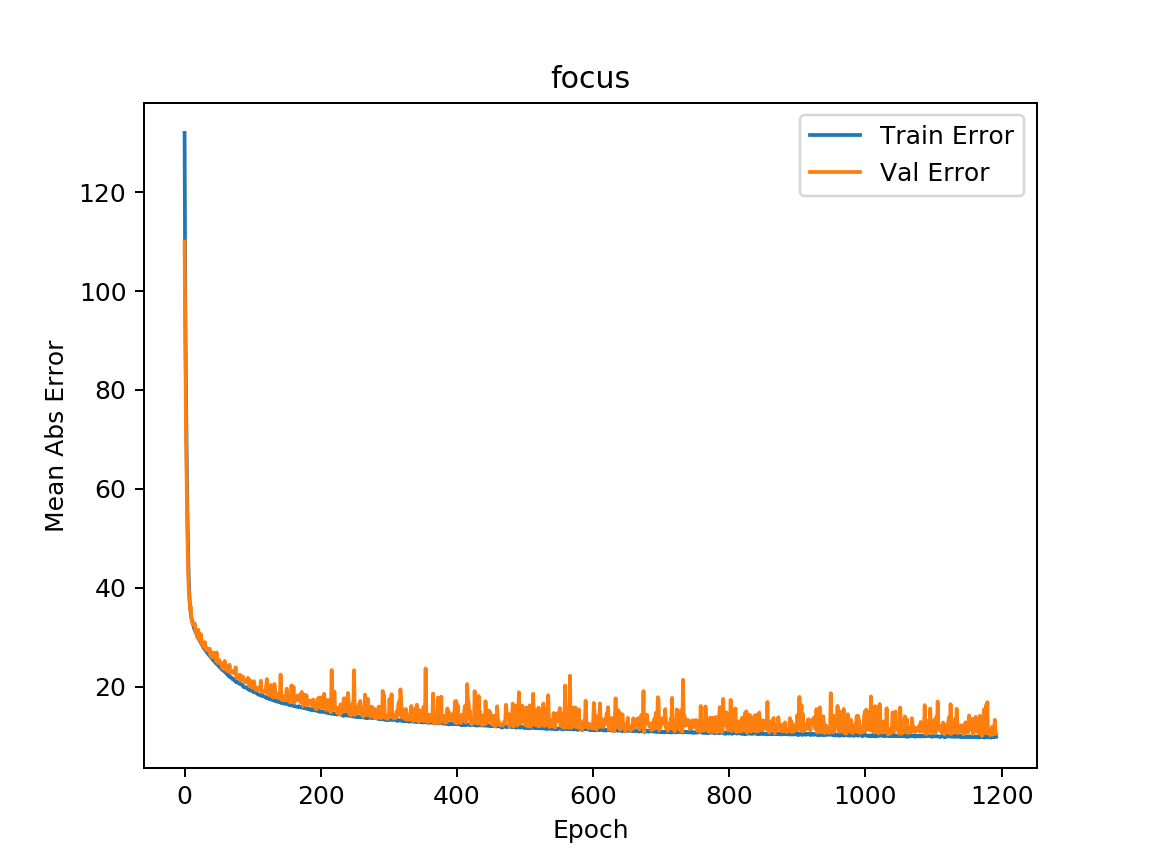

<IPython.core.display.Javascript object>


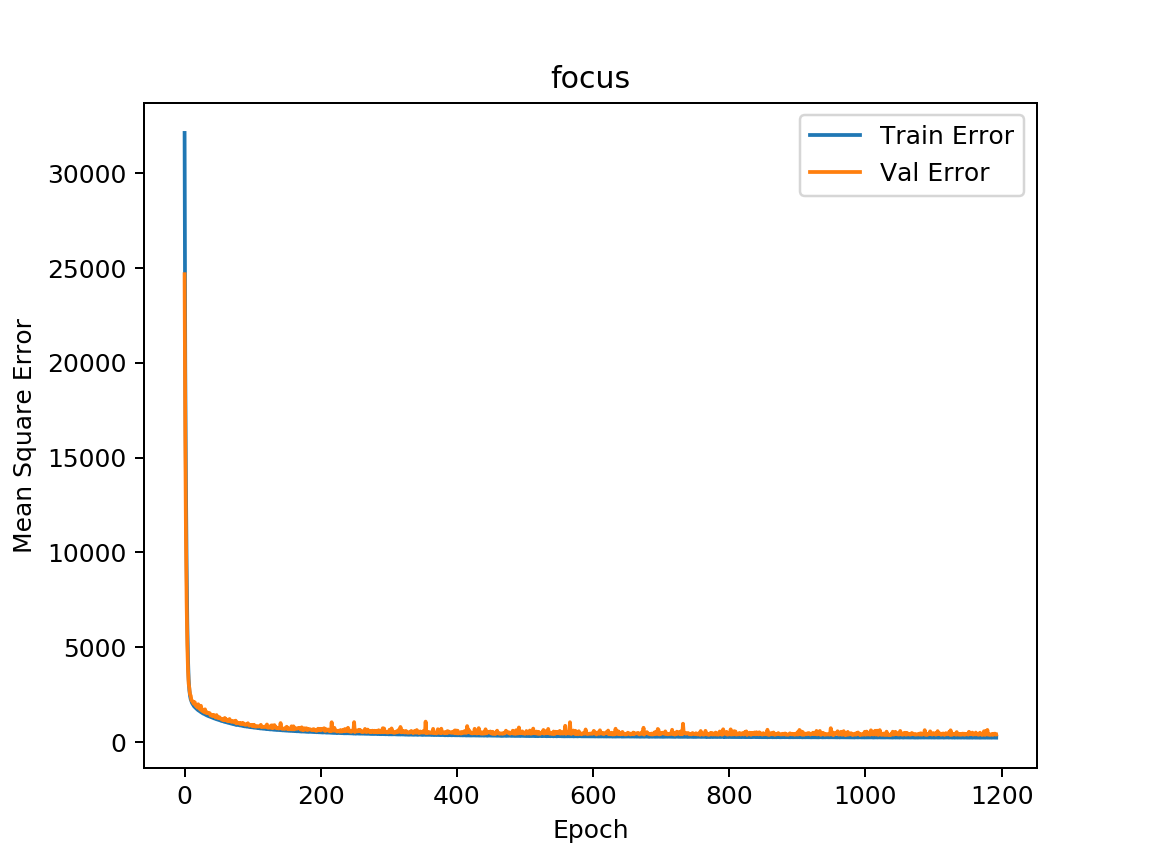

In [24]:
plot_history(histories['focus'], label="focus")

In [25]:
def show_results(label):
    loss, mae, mse = models[label].evaluate(normed_test_data, test_labels[label], verbose=0)

    print("Testing set Mean Abs Error: {:5.2f} um".format(mae))
    print("Testing set RMS: {:5.2f} um".format(np.sqrt(mse)))

    test_predictions = models[label].predict(normed_test_data).flatten()

    plt.scatter(test_labels[label], test_labels[label] - test_predictions)
    plt.xlabel('True Values [um]')
    plt.ylabel('Residuals [um]')
    minx, maxx = min(test_labels[label]), max(test_labels[label])
    plt.plot([minx, maxx], [0, 0])
    plt.show()

Testing set Mean Abs Error:  9.99 um
Testing set RMS: 18.72 um


<IPython.core.display.Javascript object>


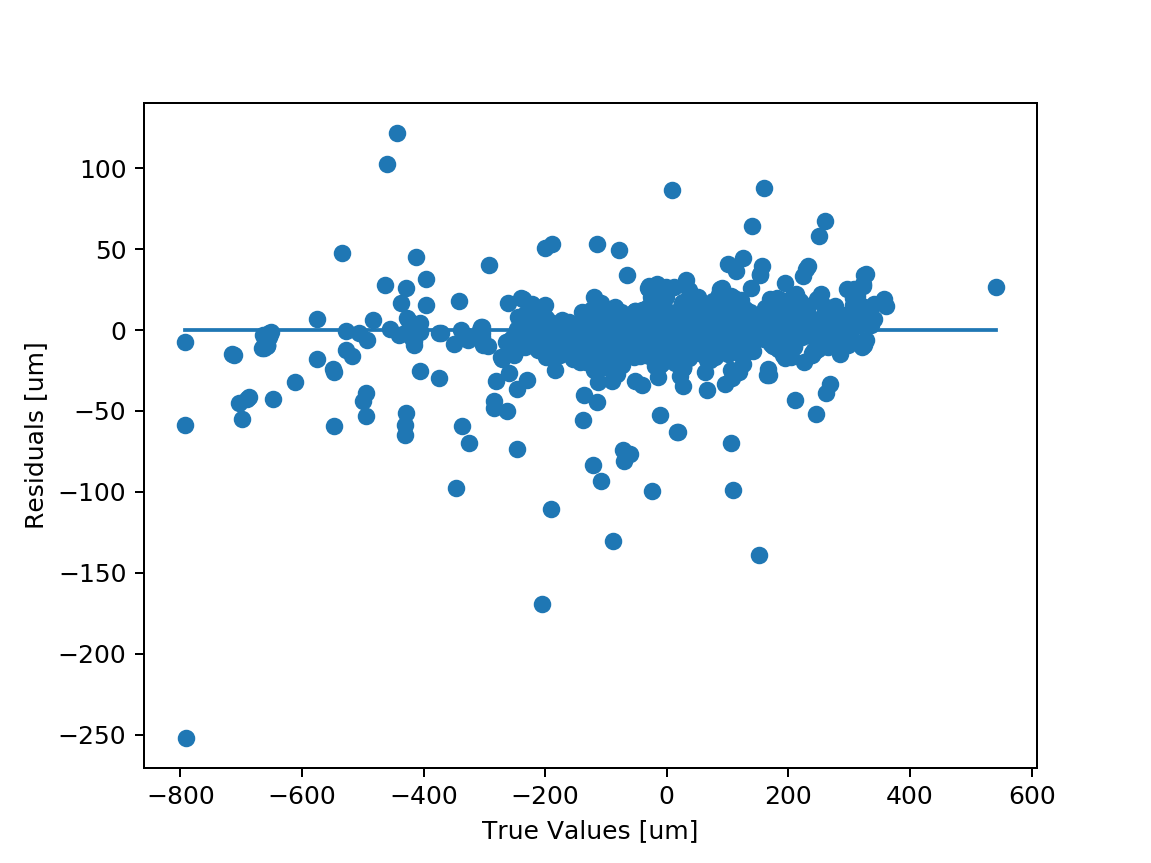

In [33]:
show_results('focus')

In [35]:
lab = 'focus'
test_predictions = models[lab].predict(normed_test_data).flatten()
diff = test_labels[lab] - test_predictions
diff.idxmax(), diff.idxmin()

(6972, 7066)

In [76]:
chk_data = normed_test_data[normed_test_data['mmirs'] > 0]
#chk.index
chk_test = test_labels['focus'][chk_data.index] 
chk_pred = models['focus'].predict(chk_data).flatten()
chk_diff = chk_test - chk_pred
chk_diff.std()

15.724786130499973

In [38]:
diff.min(), diff.max(), diff.std()

(-251.9232623329426, 121.78148620221509, 18.652668606092224)

In [ ]:
test_dataset.loc[3125]

In [ ]:
m = keras.models.load_model("/Users/tim/MMT/HALcoll/halcoll/data/tiltx_model.h5")

In [ ]:
m.evaluate(normed_test_data, test_labels['tiltx'])

In [ ]:
np.sqrt(24)

In [ ]:
normed_train_data.shape